# Statistical significance of different patterns in Kickstarter records

### _Lukas Vlcek_

## 1. Introduction

Kickstarter records contain more than 200,000 projects, with information about the ultimate success or failure of their funding campaign, the type of the proposed work, country of origin, or amounts of money asked and pledged by funders.

This information can be of high value to both proposers and funders, who need to consider whether their investment of time and money will ultimately pay off. It is possible that the historical records contain information that will allow them to make more informed decisions about the probability of successful funding and weigh those against their costs. The data analysis can also identify promising areas that seem to get more attention from funders, or to optimize the proposal to increase the chances of funding through adjustments to target amounts, the use of certain keywords, or the effect of more thorough and professional presentation.

In the following we will take a look at different trends in the data that may indicate important features and suggest a path and to building models for predicting project success, identifying opportunities, and tuning the project proposal.

## 2. Data setup

Notebook configuration

In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

Create a dataframe from a pre-processed CSV file and filter out uninformative features

In [2]:
target_path = '../data/processed'
filename = 'kick_id.csv'
datecols = ['created_at', 'deadline', 'state_changed_at', 'launched_at']
fdatpars = lambda x: datetime.datetime.fromtimestamp(int(x)).strftime('%Y-%m-%d %H:%M:%S')
df = pd.read_csv(os.path.join(target_path, filename), index_col='id', parse_dates=datecols, date_parser=fdatpars)
df = df.drop(['disable_communication'], axis='columns')

Filter out ongoing (live) and suspended projects. The live projects can be used to test predictions as the funding period concludes

In [3]:
df = df.loc[(df['state'] != 'live') & (df['state'] != 'suspended')]

Merge 162 categories to 15 more general category types for easier analysis and better statistics

In [4]:
cat_type = [x.split('/')[0] for x in df['category'].values]
df['cat_type'] = np.array(cat_type)

**Basic dataset information**

In [5]:
df.head(3)

,name,goal,pledged,usd_pledged,state,slug,country,currency,deadline,state_changed_at,created_at,launched_at,staff_pick,backers_count,blurb,spotlight,category,cat_type
id,,,,,,,,,,,,,,,,,,
18520,Grandma's are Life,15000.0,62.0,62.000000,failed,grandmas-are-life,US,USD,2016-11-18 09:32:40,2016-11-18 09:32:40,2016-10-19 08:13:18,2016-10-19 09:32:40,False,4,Raising money to help my grandmother recover f...,False,music/world music,music
21109,Meta,150.0,173.0,258.036032,successful,meta,GB,GBP,2015-05-06 17:00:00,2015-05-06 17:00:12,2015-04-07 10:07:05,2015-04-07 18:37:44,False,11,My work is performance based but I branch out ...,True,art/performance art,art
24380,Puss N' Books: A relaxing cat cafe and bookstore.,20000.0,776.0,776.000000,failed,puss-n-books-a-relaxing-cat-cafe-and-bookstore,US,USD,2015-11-26 11:25:33,2015-11-26 11:25:33,2015-10-25 11:32:25,2015-10-27 11:25:33,False,18,A sanctuary for humans and felines alike! Come...,False,food/spaces,food


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 238456 entries, 18520 to 2147476221
Data columns (total 18 columns):
name                238455 non-null object
goal                238456 non-null float64
pledged             238456 non-null float64
usd_pledged         238456 non-null float64
state               238456 non-null object
slug                238456 non-null object
country             238456 non-null object
currency            238456 non-null object
deadline            238456 non-null datetime64[ns]
state_changed_at    238456 non-null datetime64[ns]
created_at          238456 non-null datetime64[ns]
launched_at         238456 non-null datetime64[ns]
staff_pick          238456 non-null bool
backers_count       238456 non-null int64
blurb               238441 non-null object
spotlight           238456 non-null bool
category            238456 non-null object
cat_type            238456 non-null object
dtypes: bool(2), datetime64[ns](4), float64(3), int64(1), object(8)
memory us

**Comment:** Out of the 18 columns in the processed dataset with no missing values, we can identify two main target properties.
1. Column 'state' provides the classification of each project as 'successful' or 'failed' based on whether the funding goal was reached.
2. Since the success or failure of a campaign is directly determined by 'pledges' by funders reaching or exceeding the 'goals' set by the proposers, we can also consider the actual amounts of pledged funds as another target. Such a task would go beyond simple classification and could provide highly valuable estimate for the proposers, and possibly suggest strategies not only to reach goals, but also maximize the amount of funding.

The remaining features can be potentially used for the prediction of the success or failure. We will explore the relations of these features to the targets and their potential value as predictors.

## 2. Basic statistics for different features

First we will explore the basic characteristics of different property distributions and correlations within the data.

### 2.1 Overall success/failure rates

**Q:** What is the average success rate of the submitted proposals?

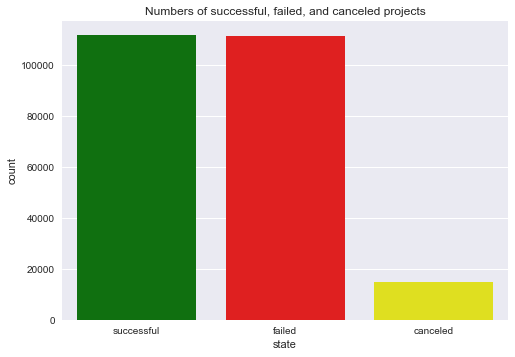

In [7]:
sns.set_context("notebook")
order = ['successful','failed','canceled']
colors = ['green','red','yellow']
sns.countplot(x='state', data=df, order=order, palette=dict(zip(order,colors)))
plt.title("Numbers of successful, failed, and canceled projects")

**Observation:** Out of the completed funding campains, about half were successful, i.e., the pledged amounts reached or exceeded the goal amounts. We can consider this 50% success rate as the first rough baseline for measuring the quality of our future predictive models. In principle, cancelled projects could be also classified as 'not successful' and we may investigate whether there are some predictors of canceled projects.

Mininimum success rate:
 launched_at
2014-07-31    0.268002
Freq: M, dtype: float64


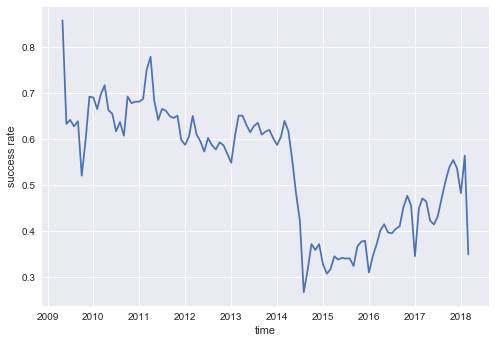

In [8]:
# create time series of success rates averaged over months
sr_rate_time = pd.Series(np.int_(df['state'] == 'successful'), index=df['launched_at']).resample('M').mean()

# plot success rate 
plt.plot(sr_rate_time.index, sr_rate_time)
plt.xlabel('time')
plt.ylabel('success rate')
print('Mininimum success rate:\n', sr_rate_time[sr_rate_time == sr_rate_time.min()])

The success rate changes over time, possibly with changes in rules. We can test how significant this change is.
First, we plot a histogram of the success rates to visually check deviations from normality.

We will add a new column which indicates whether the data were taken before or after this change. This can be later used for easy analysis.

In [9]:
df['period'] = df['launched_at'] > '2014-06-01'

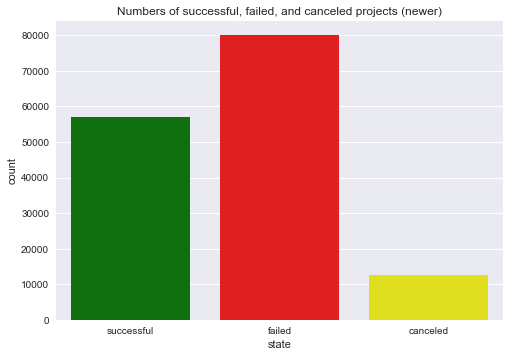

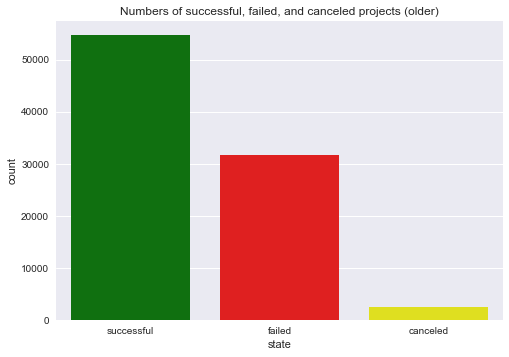

In [10]:
sns.set_context("notebook")
sns.countplot(x='state', data=df[df['period']], order=order, palette=dict(zip(order,colors)))
plt.title("Numbers of successful, failed, and canceled projects (newer)")
plt.show()
sns.countplot(x='state', data=df[~df['period']], order=order, palette=dict(zip(order,colors)))
plt.title("Numbers of successful, failed, and canceled projects (older)")

Test whether the data in the two periods are normally distributed

New mean and variance: 0.40159672809070934 0.005188786778248721 45
Old mean and variance: 0.6343678682082681 0.0033634392266313463 62


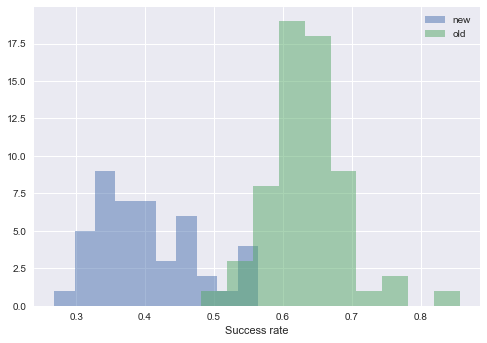

In [11]:
# make new dataframes with new and old data
dfn = df.loc[df.period].copy()
dfo = df.loc[~df.period].copy()
srn_rate = pd.Series(np.int_(dfn['state'] == 'successful'), index=dfn['launched_at']).resample('M').mean()
sro_rate = pd.Series(np.int_(dfo['state'] == 'successful'), index=dfo['launched_at']).resample('M').mean()
#plt.plot(srn_rate.index, srn_rate)
#plt.plot(sro_rate.index, sro_rate)
#print(srn_rate)
plt.hist(srn_rate, alpha=0.5, label='new')
plt.hist(sro_rate, alpha=0.5, label='old')
plt.legend()
plt.xlabel('Success rate')
xbar_n = np.mean(srn_rate) ; s2_n = np.var(srn_rate, ddof=1) ; n_n = srn_rate.shape[0]
xbar_o = np.mean(sro_rate) ; s2_o = np.var(sro_rate, ddof=1) ; n_o = sro_rate.shape[0]
print('New mean and variance:', xbar_n, s2_n, n_n)
print('Old mean and variance:', xbar_o, s2_o, n_o)

In [12]:
# construct array for the empirical cummulative distribution function
def ecdf(values):
    y = np.linspace(0., 1., values.shape[0])
    x = np.sort(values)
    return x, y

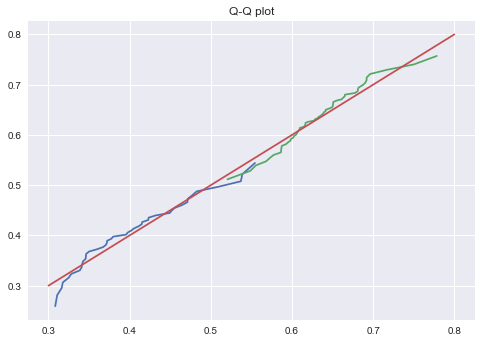

In [13]:
from scipy.stats import norm
# construct Q-Q plot empirical vs. theoretical quantile functions
x, y = ecdf(srn_rate)
x_norm = norm.ppf(y, loc=np.mean(srn_rate), scale=np.std(srn_rate))
plt.plot(x, x_norm)
x, y = ecdf(sro_rate)
x_norm = norm.ppf(y, loc=np.mean(sro_rate), scale=np.std(sro_rate))
plt.plot(x, x_norm)
plt.plot([0.3, 0.8], [0.3, 0.8])
plt.title('Q-Q plot')

The Q-Q plot shows reasonably normal distributions.

The success rates in the two distinct periods are clearly different. The two-sample t-test assuming approximately normal.

In [14]:
from scipy.stats import ttest_ind
ttest_ind(srn_rate, sro_rate, equal_var=False)

Ttest_indResult(statistic=-17.876122839223616, pvalue=4.9819819244240387e-30)

Negligible p-value confirms the obvious.

In [15]:
# set dfn to df for the following analysis
df = dfn.copy()
df.shape

(149738, 19)

### 2.2 Overall funding goals vs. pledges

One of the main features of interest in the dataset are the pledges and goals, whose ratio ultimately determines the success of the funding campaign.

The first orientation about the scope of the amounts found on Kickstarter can be provided by basic statistical descriptors.

In [16]:
df[['goal', 'usd_pledged']].describe()

,goal,usd_pledged
count,1.497380e+05,1.497380e+05
mean,6.228465e+04,1.128295e+04
std,1.397293e+06,1.170641e+05
min,1.000000e+00,0.000000e+00
25%,2.000000e+03,1.600000e+01
50%,5.500000e+03,5.000000e+02
75%,2.000000e+04,4.420000e+03
max,1.000000e+08,2.033899e+07


We see that the amounts range from zero to tens of millions of dollars. The summary statistics can be therefore skewed by the the infrequent but very large maximum values.

To better analyze the wide ranges of values, we can use the statistics on the logarithmic scale.

In [17]:
# take logarithms of the goal and pledged amounts. Eliminate zeros before taking logarithms
goal_log = np.log10(df.loc[df['goal'] > 0.0]['goal'])
pledged_log = np.log10(df.loc[df['pledged'] > 0.0]['pledged'])
received_log = np.log10(df.loc[df['pledged'] > df['goal']]['pledged'])
goal_log_mu = 10**np.mean(goal_log)
pledged_log_mu = 10**np.mean(pledged_log)
received_log_mu = 10**np.mean(received_log)
print("Log-average of the goals:", goal_log_mu, 'dollars')
print("Log-average of the pledges:", pledged_log_mu, 'dollars')
print("Log-average of the received:", received_log_mu, 'dollars')

Log-average of the goals: 5708.512354108499 dollars
Log-average of the pledges: 716.5798277869787 dollars
Log-average of the received: 6072.298254888268 dollars


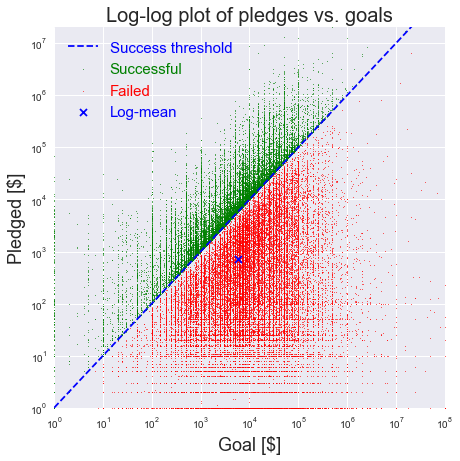

In [18]:
f, ax = plt.subplots(figsize=(7, 7))
ax.set(xscale="log", yscale="log")
sns.regplot("goal", "pledged", df.loc[(df.state == 'successful')], scatter_kws={"s": 1}, fit_reg=False, color='green',label='Successful')
sns.regplot("goal", "pledged", df.loc[(df.state == 'failed')], scatter_kws={"s": 1}, fit_reg=False, color='red',label='Failed')
#sns.regplot("goal", "pledged", df.loc[df.state == 'canceled'], scatter_kws={"s": 1}, fit_reg=False, color='black',label='Canceled')
plt.plot([1,1e8],[1,1e8],linestyle='--', color='blue', label='Success threshold')
plt.scatter([goal_log_mu], [pledged_log_mu], marker='x', c='b', label='Log-mean')
plt.xlim(1,df.goal.max())
plt.ylim(1,df.usd_pledged.max())
plt.xlabel('Goal [$]', fontsize=18)
plt.ylabel('Pledged [$]', fontsize=18)
leg = plt.legend(fontsize=15)
leg.get_texts()[0].set_color('blue')
leg.get_texts()[1].set_color('green')
leg.get_texts()[2].set_color('red')
leg.get_texts()[3].set_color('blue')


plt.title('Log-log plot of pledges vs. goals', fontsize=20)

**Observations:** We can see that the goals and pledged amounts follow roughly a lognormal distribution, with means of around \$5000 for goals, and \$1000 for pledges.

Concerning the predictive value of this data, we can look at the dependence of pledged amount on goals and how the goal may influence the likelihood of success and the pledged amount.

Log-log plot of pledges vs. goals for different categories


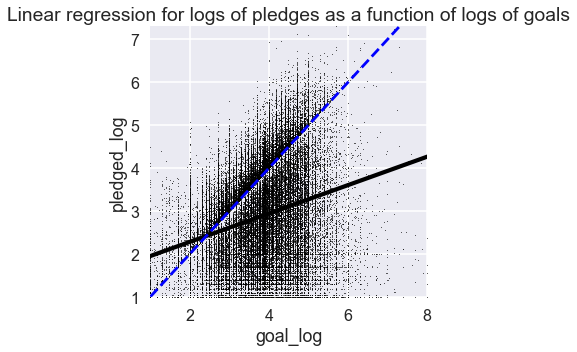

In [19]:
#df_log = df.loc[df['pledged'] > df['goal']].copy()
df_log = df.loc[df['pledged'] > 0.0].copy()

df_log['goal_log'] = np.log10(df_log['goal'].values)
df_log['pledged_log'] = np.log10(df_log['pledged'].values)
#df_log['received_log'] = df_log['pledged_log']*df_log['succeeded']

sns.set_context("poster")
print('Log-log plot of pledges vs. goals for different categories')
lmp = sns.lmplot(x="goal_log", y="pledged_log", data=df_log, scatter_kws={"s": 1, "color":'black'}, line_kws={"color":'black'})
#lmp.set(xscale="log", yscale="log")
plt.plot([1,1e8],[1,1e8],linestyle='--', color='blue', label='Success threshold')
plt.xlim(1,df_log.goal_log.max())
plt.ylim(1,df_log.pledged_log.max())
plt.title('Linear regression for logs of pledges as a function of logs of goals')

Log-log plot of pledges vs. goals for different categories


(1, 7.3083293031434344)

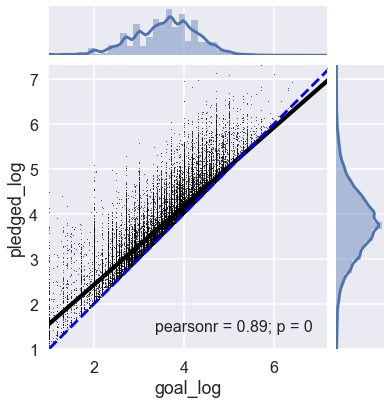

In [20]:
df_log = df.loc[df['pledged'] > df['goal']].copy()
#df_log = df.loc[df['pledged'] > 0.0].copy()

df_log['goal_log'] = np.log10(df_log['goal'].values)
df_log['pledged_log'] = np.log10(df_log['pledged'].values)
#df_log['received_log'] = df_log['pledged_log']*df_log['succeeded']

sns.set_context("poster")
print('Log-log plot of pledges vs. goals for different categories')
#lmp = sns.lmplot(x="goal_log", y="pledged_log", data=df_log, scatter_kws={"s": 1, "color":'black'}, line_kws={"color":'black'})
#lmp.set(xscale="log", yscale="log")
lmp = sns.jointplot(x="goal_log", y="pledged_log", data=df_log, kind='reg', scatter_kws={"s": 1, "color":'black'}, line_kws={"color":'black'})
plt.plot([1,1e8],[1,1e8],linestyle='--', color='blue', label='Success threshold')
plt.xlim(1,df_log.goal_log.max())
plt.ylim(1,df_log.pledged_log.max())
#plt.title('Linear regression for logs of pledges as a function of logs of goals')

**Observation:** While the pledged amounts rise with rising goals, the black regression line has a lower slope than the threshold line. On average, the success rate will fall with the goals. Obviously, the linear regression may not be the most appropriate predictor of the pledged amount, as the datapoints are not distributed along a line and the prediction errors are large.

Logistic regression may provide a better prediction of success as a function of goal amounts.


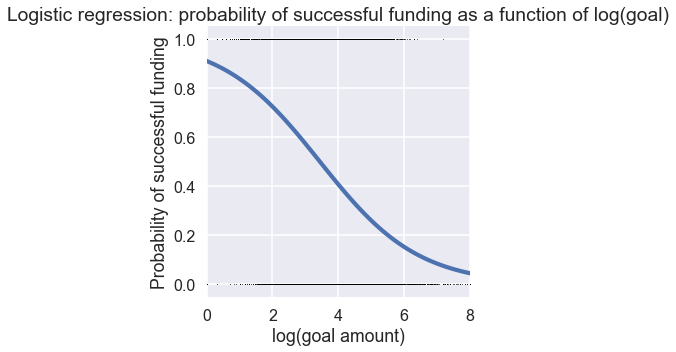

In [21]:
df_log = df.loc[df['pledged'] > 0.0].copy()
df_log['goal_log'] = np.log10(df_log['goal'].values)
df_log['succeeded'] = df_log['state'] == 'successful'
lmp = sns.lmplot(x="goal_log", y="succeeded", data=df_log, logistic=True, ci=None, scatter_kws={"s":1,"color":'black'})
plt.xlim(0,df_log.goal_log.max())
plt.xlabel('log(goal amount)')
plt.ylabel('Probability of successful funding')
plt.title('Logistic regression: probability of successful funding as a function of log(goal)')

**Observation:** The logistic regression line indicates that lower goals result in higher success, and that the break-even point of probability=0.5 is at about \$1,000.


Another interesting feature of the pledged-goal distribution is the depletion region right below the threshold for successful funding (dashed blue line), followed by sharp increase of pledged amounts just at the threshold.
This feature in the data can be made more obvious on a plot of completed project numbers as a function of pledged/goal ratio.

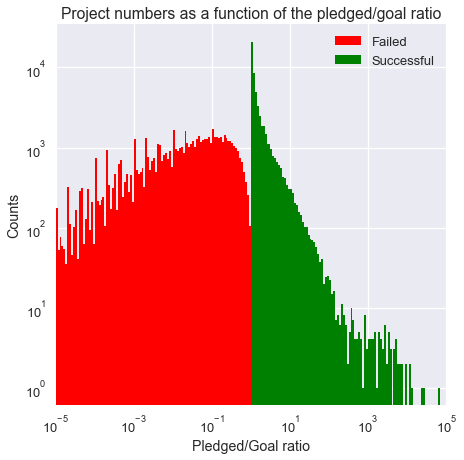

In [22]:
sns.set_context("talk")
f, ax = plt.subplots(figsize=(7, 7))
ax.set(xscale="log", yscale='log')
logbins=np.logspace(-5, 5, num=201, endpoint=True)
ratio = df['pledged']/df['goal']
success = ratio > 1.0
#plt.hist(ratio, bins=logbins, label='Failed', normed=False)
plt.hist(ratio[np.logical_not(success)], bins=logbins, color='red', label='Failed')
plt.hist(ratio[success], bins=logbins, color='green', label='Successful')
#plt.vlines(1.0, 1e-10, 1e4)
plt.legend()
plt.xlabel('Pledged/Goal ratio')
plt.ylabel('Counts')
plt.xlim(1e-5,1e5)
plt.title("Project numbers as a function of the pledged/goal ratio")

Here we can clearly see that once the funding approaches the success threshold, the probability of reaching and exceeding it rises. This information should be reproduced by a model predicting the pledged amounts. An interesting question may be about the origin of this behavior. Possible answers may include bigger interest from funders simply because the project seems on a good track. The proposers may also increase advertising activity to reach the goal. However to indentify the likely origin of this trend, additional data would have to be collected.


**Note:** It may be also worth analyzing why exactly the distribution of goals and pledges is approximately log-normal. These distributions typically result from the products of independent random variables, while normal distributions result from their sums. This insight may also help us in the construction of a model for predicting pledged amounts.

** Look at extreme goals **

**Q:** The maximum goals can reach up to very large amounts \$100M. Can these proposals be legitimate? Is setting such high goals a good strategy? Unless the amount is necessary for a functional project, this does not seem a good choice because it is unlikely to be fully funded.

In [23]:
df_max = df.loc[df['goal'] == 1e8][['name','category','usd_pledged','backers_count','country','blurb']].sort_values(by='category').reset_index()
print("Number of projects asking maximum amount ($100M):", df_max.shape[0])
df_max.tail()

Number of projects asking maximum amount ($100M): 19


,id,name,category,usd_pledged,backers_count,country,blurb
14,1119122774,"Help me start a fair media company, Trump Media",journalism/video,1.000000,1,US,"You might be asking why I decided to call it ""..."
15,487345242,Billionaire Boy Blog (Canceled),publishing/young adult,0.000000,0,DK,An exclusive blog about a 18 year old milliona...
16,953415668,Currency Free System,technology/software,0.502121,1,MX,CF is an independent currency system and a tra...
17,1601563193,Our future,technology/space exploration,0.928942,1,AU,The new century has begun may our life's get e...
18,2083255961,A Billion Pixels...,technology/web,56.000000,6,US,"A billion pixel website, a billion pixel displ..."


Examples of project descriptions

In [24]:
# Trump media company
print(df_max.loc[14][6])

You might be asking why I decided to call it "Trump Media," well its simple. Our media will "trump" the lame stream media


In [25]:
# Billionaire boy
print(df_max.loc[15][6])

An exclusive blog about a 18 year old millionaire.
The blod will consist of fashion, cars, sport, travelling and much more.


In [26]:
# New currency
print(df_max.loc[16][6])

CF is an independent currency system and a trading tool that runs parallel to all existing currency systems.


In [27]:
df_max.set_index('id').mean()

usd_pledged      7.744468
backers_count    1.000000
dtype: float64

** A:** Most of the 18 extreme goals of \$100M seem suspicious and unrealistic, with the proposers not fully understanding how the Kickstarter funding works (all or nothing). Based on the averaged amounts pledged (\$7.75) and the number of funders (1), these extreme goals do not attract funding.

## 3. Success of funding based on project categories

A lot of the variation in the financial goals may depend on the category of the projects, with smaller art projects involving a few people not needing much funding, and technology mass manufacturing type of projects needing large amounts.

For instance, the proposers may be able to optimize the amounts asked, or, if they have multiple ideas, choose a category with the highest likelihood of funding.

** Questions **

1. Are the success rates and funding strongly dependent on the category?
2. What are the most promising categories in terms of likelihood of funding and the overal amounts obtained?

In [28]:
# number of different categories
print("Number of categories:", df['category'].value_counts().shape[0])
print("Most frequent category:", df['category'].value_counts().head(1))
print("Least frequent category:", df['category'].value_counts().tail(1))

Number of categories: 161
Most frequent category: fashion/apparel    5447
Name: category, dtype: int64
Least frequent category: crafts/taxidermy    8
Name: category, dtype: int64


** Observation **
* There are too many (169) categories for easy evaluation, going from the most frequent 'games/video games' (7340) to the least frequent 'crafts/taxidermy' (11)
* It is easier to analyze the trends in terms for general category types, that can be extracted from the category names.
* This coarse-graining will also improve the statistics for model development.

** Category types statistics **

In [29]:
print("Number of categories:\n", df['cat_type'].value_counts())

Number of categories:
 technology      21100
film & video    17968
publishing      15591
music           14661
games           13813
food            12619
fashion         12119
art             10943
design           6882
comics           5647
photography      5000
crafts           4790
theater          3640
journalism       3337
dance            1628
Name: cat_type, dtype: int64


The most frequent category type is 'technology', while the least frequent is 'dance'.

** Q: What are the success rates for different categories? **

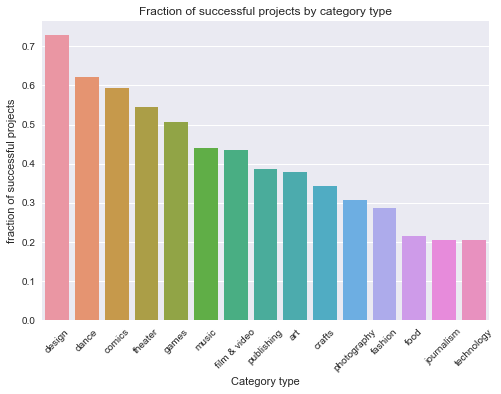

In [30]:
sns.set_context("notebook")
pt = df.pivot_table(index='cat_type', columns='state', values='country', aggfunc='count')
x = (pt['successful']/(pt.sum(axis='columns'))).to_frame(name='ratio').sort_values(by='ratio', ascending=False)
sns.barplot(x=x.index, y='ratio', data=x)
plt.xticks(rotation=45)
plt.xlabel('Category type')
plt.ylabel('fraction of successful projects')
plt.title('Fraction of successful projects by category type')

**A:** Dance and design have the highest success rate, while technology and journalism the least

**Q:** What are the median amounts targeted and pledged?

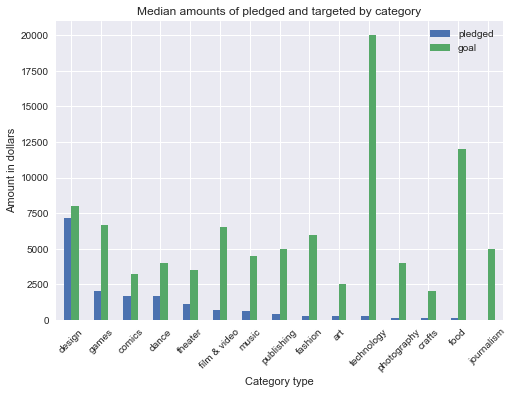

In [31]:
gp = df.groupby('cat_type').median()[['goal','pledged']].sort_values(by='pledged', ascending=False)
gp.plot(y=['pledged','goal'], kind='bar')
plt.xticks(rotation=45)
plt.xlabel('Category type')
plt.ylabel('Amount in dollars')
plt.title('Median amounts of pledged and targeted by category')

**Q:** What are the total amounts invested in different categories?

             pledged
cat_type            
dance     6948743.08


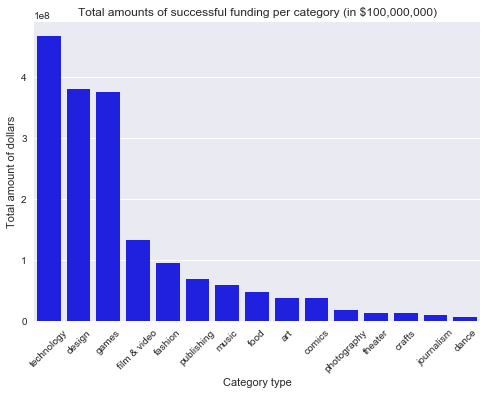

In [32]:
pl = df.loc[df.state == 'successful'].groupby('cat_type').sum()[['pledged']].sort_values(by='pledged', ascending=False)
sns.barplot(x=pl.index, y='pledged', data=pl, color='blue')
plt.xlabel('Category type')
plt.ylabel('Total amount of dollars')
plt.title("Total amounts of successful funding per category (in $100,000,000)")
plt.xticks(rotation=45)
print(pl.tail(1))

**A:** While the investments into technolgy were ~ \$600M, even the smallest dance category still attracted \$13M.

Given the low median for technology, the successful technology projects attract large amounts

A more detailed look at the goals and funding per category may reveal some interesting features.

Log-log plot of pledges vs. goals for different categories


(1, 20338986.27)

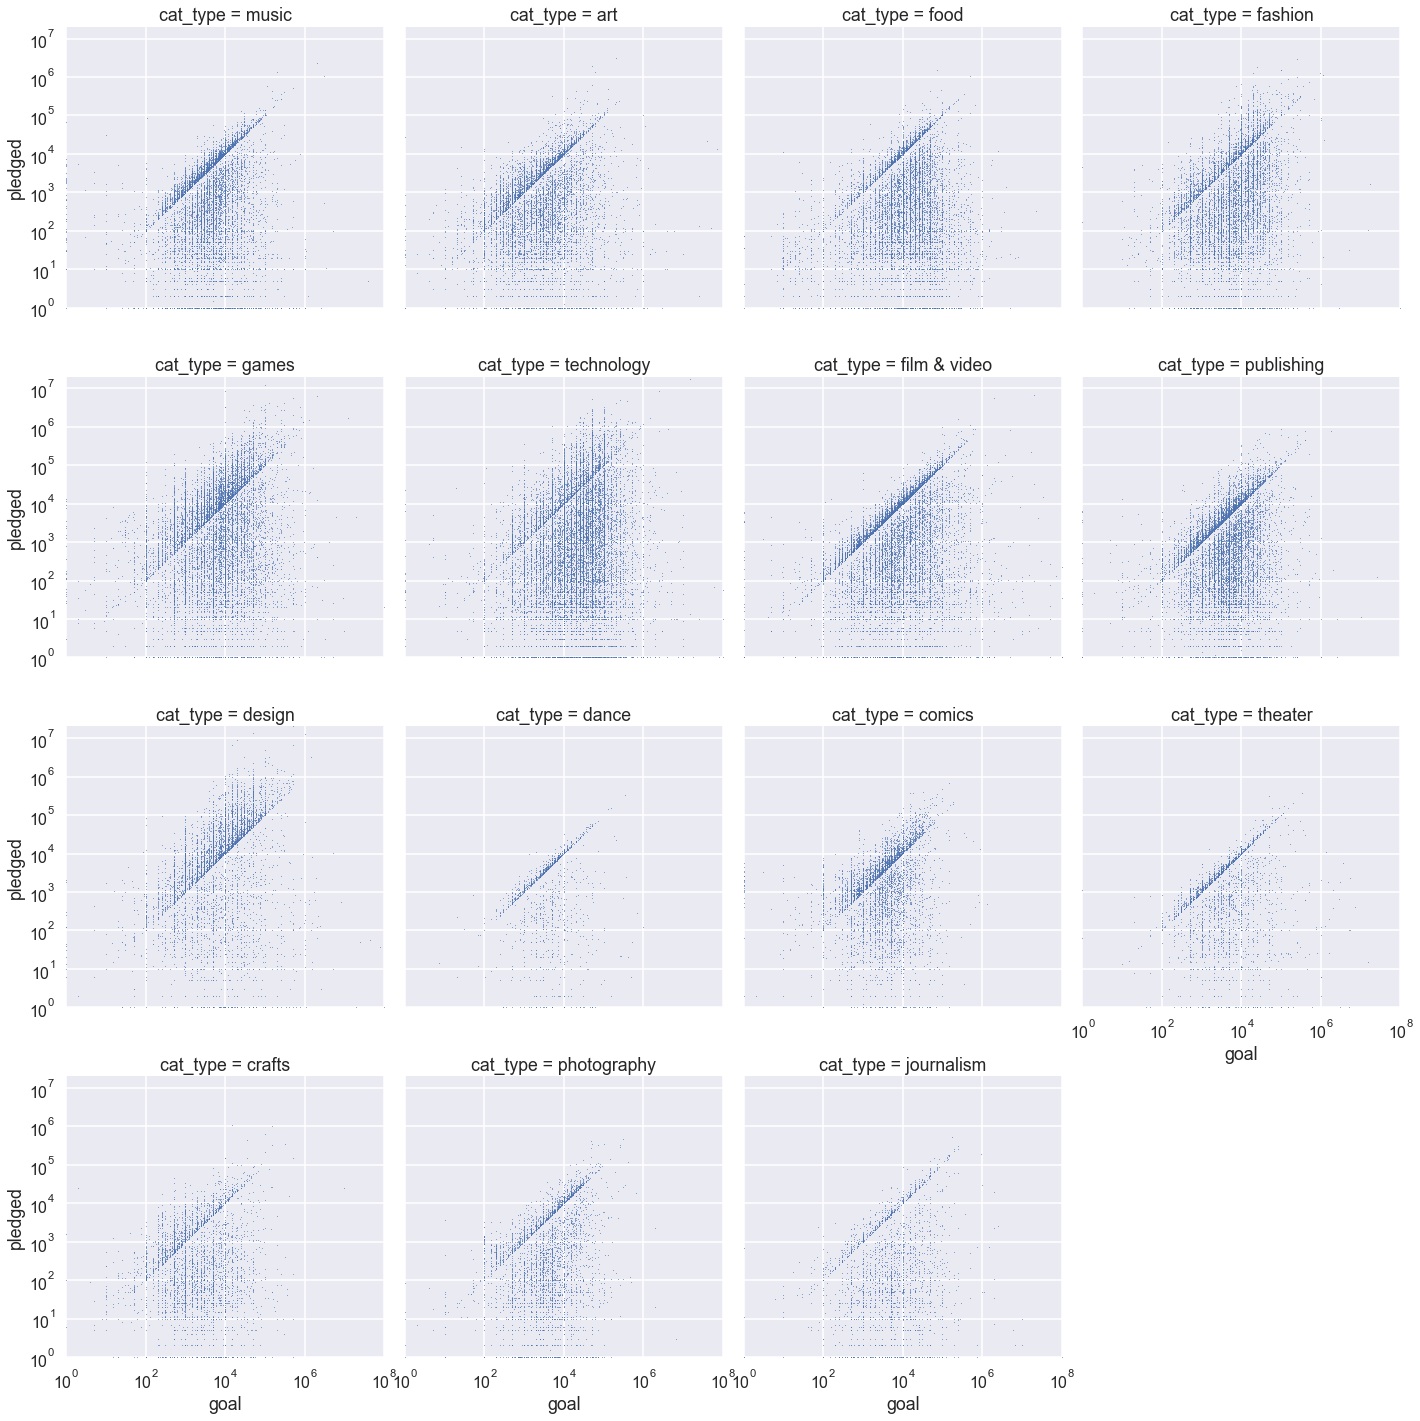

In [33]:
sns.set_context("poster")
print('Log-log plot of pledges vs. goals for different categories')
lmp = sns.lmplot(x="goal", y="pledged", col="cat_type", col_wrap=4, data=df, fit_reg=False, scatter_kws={"s": 1})
lmp.set(xscale="log", yscale="log")
plt.xlim(1,df.goal.max())
plt.ylim(1,df.usd_pledged.max())

The log-log plots of pledges vs. goals do reveal differences in the funding patterns in different categories. For instance, there is a high chance of pledges substantially exceeding the goal amount for the categories of design and games. This may be because the product can be easily replicated to satisfy larger number of funders/customers. In categories such as dance, theater, or film&video, the funding target is achieved with high probability, but the total pledged amounts to not exceed it by much. This may be given by either poor scalability of the project outputs or a limited pool of the funders/audience. 

These differences should be reflected in the future predictive model of pledged amounts.

## 4. Are staff picks predictive?

* The Kicksarter staff can review a project and judge its merits based on its content.
* How good are these recomendations as a predictor of the actual success?
* Even though the staff pick is useful as a predictor for funders, it may play a different role for proposers. Since a staff pick seems to help in funding, it may be worth exploring whether the proposal can be optimized to increase the chance of being picked. In this case the staff picks can be considered as a target for predictive modeling, and one of the features to be used for optimization of proposals. 

In [34]:
pt = df.pivot_table(index='staff_pick', columns='state', values='country', aggfunc='count')
print("Fraction of staff-picked projects:", df['staff_pick'].sum()/len(df))
print("Success rate of a random project:      ", pt.loc[:, 'successful'].sum()/(pt.loc[True,:].sum()+pt.loc[False,:].sum()))
print("Success rate of a staff-picked project:",pt.loc[True, 'successful']/pt.loc[True,:].sum())
print("Success rate of a non-picked project:  ",pt.loc[False, 'successful']/pt.loc[False,:].sum())

Fraction of staff-picked projects: 0.106779842124
Success rate of a random project:       0.3814462594665349
Success rate of a staff-picked project: 0.817499530928
Success rate of a non-picked project:   0.329318350044


** A: Staff pick almost doubles the chances of a project being succesful. **

**Q:**
* Can a model based on the statistical data beat the staff pick as a predictor?
* Can a combination of the data with the staff pick improve the predictions?

We have seen that Dance and Design categories have success rates aroud 75%. Can a combination of the category and staff pick improve the results? (If simply successful funding is the measure)

In [35]:
success = df.loc[(df.staff_pick == True) & (df.cat_type == 'dance') & (df.state == 'successful')]['goal'].count()/df.loc[(df.staff_pick == True) & (df.cat_type == 'dance')]['goal'].count()
print('Success rate for staff-picked dance projects:', success)

Success rate for staff-picked dance projects: 0.869230769231


In [36]:
success = df.loc[(df.staff_pick == True) & (df.cat_type == 'design') & (df.state == 'successful')]['goal'].count()/df.loc[(df.staff_pick == True) & (df.cat_type == 'design')]['goal'].count()
print('Success rate for staff-picked dance projects:', success)

Success rate for staff-picked dance projects: 0.949326999208


**A:** Simply combining the staff pick with the design category brings the success rate to 95%!

**Summary**

There is a lot of structure in the data, which can be further analyzed and quantified by statistical methods, which will allow for rigorous hypothesis testing, and the results can be used in the design of predictive models useful for both funders and enterpreneurs. These tasks will be addressed next.


Is there a significant dependence between different categorical variables?
'cat_type' vs. 'country'
'cat_type' vs. 'staff_pick'
'country' vs. 'staff_pick'
'succeeded' vs. everything

5238.64869876 0.0 294


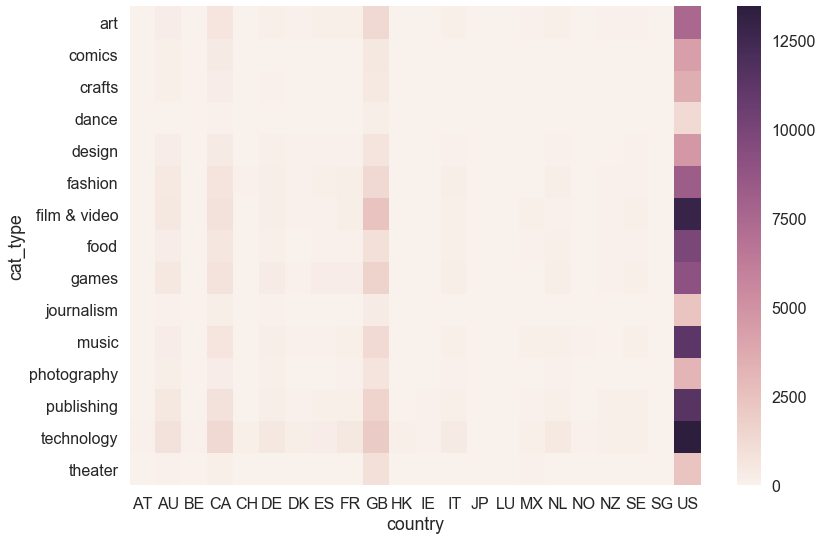

In [37]:
from scipy.stats import chi2_contingency
df['succeeded'] = df['state'] == 'successful'
df['indicator'] = 1
# cat_type vs. origin contingency table (pivot table)
pt = df.pivot_table(index='cat_type',columns='country', aggfunc=np.sum, values='indicator', fill_value=0)#, margins=True)
chi2, p, dof, _ = chi2_contingency(pt.values)
print(chi2, p, dof)
sns.heatmap(pt)

1400.58215383 1.04627493345e-163 238


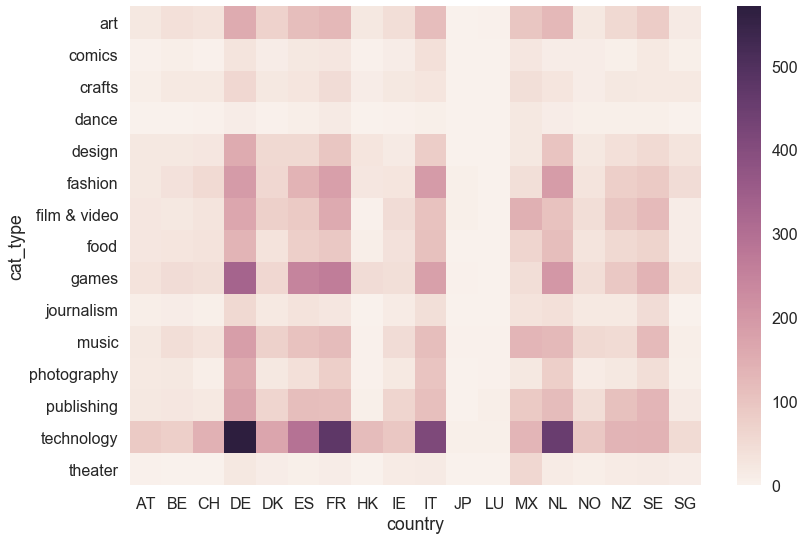

In [38]:
# cat_type vs. origin contingency table (pivot table)
pt = df.pivot_table(index='cat_type',columns='country', aggfunc=np.sum, values='indicator', fill_value=0)#, margins=True)
pt = pt.drop(['US','GB','CA','AU'], axis=1)
chi2, p, dof, _ = chi2_contingency(pt.values)
print(chi2, p, dof)
sns.heatmap(pt)

In [39]:
pt = df.pivot_table(index='staff_pick',columns='cat_type', aggfunc=np.sum, values='indicator', fill_value=0)#, margins=True)
chi2, p, dof, _ = chi2_contingency(pt.values)
print(chi2, p, dof)

2657.59776708 0.0 14


In [40]:
pt = df.pivot_table(index='staff_pick',columns='country', aggfunc=np.sum, values='indicator', fill_value=0)#, margins=True)
chi2, p, dof, _ = chi2_contingency(pt.values)
print(chi2, p, dof)

265.550986392 3.04504715036e-44 21


In [41]:
pt = df.pivot_table(index='country',columns='succeeded', aggfunc=np.sum, values='indicator', fill_value=0)#, margins=True)
chi2, p, dof, _ = chi2_contingency(pt.values)
print(chi2, p, dof)

874.597881445 1.33677347628e-171 21


In [42]:
pt = df.pivot_table(index='cat_type',columns='succeeded', aggfunc=np.sum, values='indicator', fill_value=0)#, margins=True)
chi2, p, dof, _ = chi2_contingency(pt.values)
print(chi2, p, dof)

12130.5705123 0.0 14


91.7055349683 1.0 294


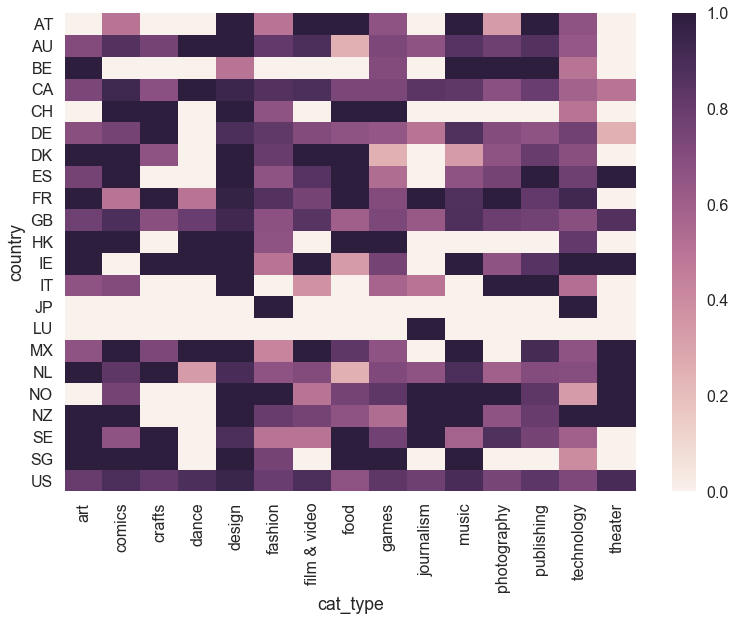

In [43]:
pt = df.loc[df['staff_pick'] == True].pivot_table(index='country',columns='cat_type', aggfunc=np.mean, values='succeeded', fill_value=0)#, margins=True)
chi2, p, dof, _ = chi2_contingency(pt.values)
print(chi2, p, dof)
sns.heatmap(pt)

91.7055349683 1.0 294


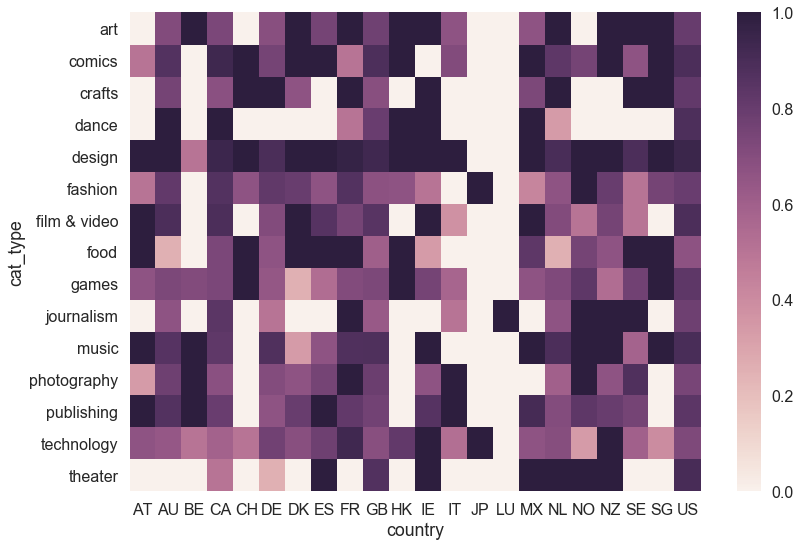

In [44]:
pt = df.loc[df['staff_pick'] == True].pivot_table(index='cat_type',columns='country', aggfunc=np.mean, values='succeeded', fill_value=0)#, margins=True)
chi2, p, dof, _ = chi2_contingency(pt.values)
print(chi2, p, dof)
sns.heatmap(pt)

32.0837756885 1.0 294


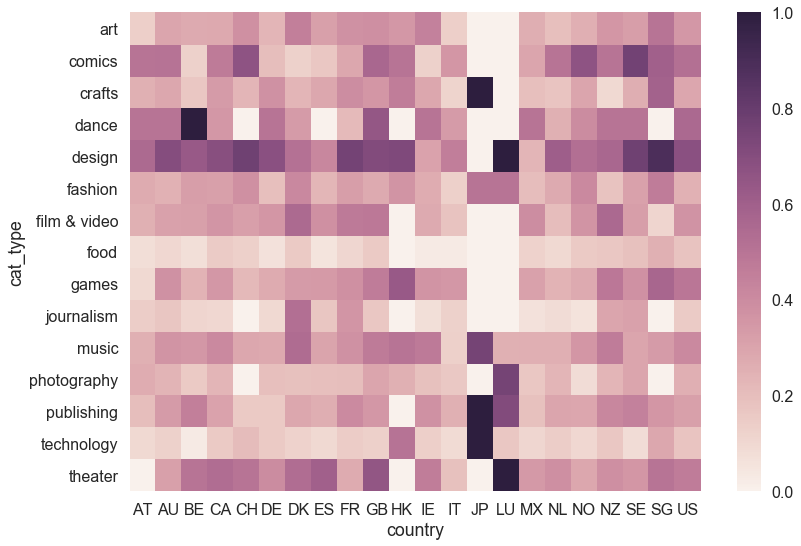

In [45]:
pt = df.loc[df['staff_pick'] == False].pivot_table(index='cat_type',columns='country', aggfunc=np.mean, values='succeeded', fill_value=0)#, margins=True)
chi2, p, dof, _ = chi2_contingency(pt.values)
print(chi2, p, dof)
sns.heatmap(pt)

19.3450674453 1.0 294


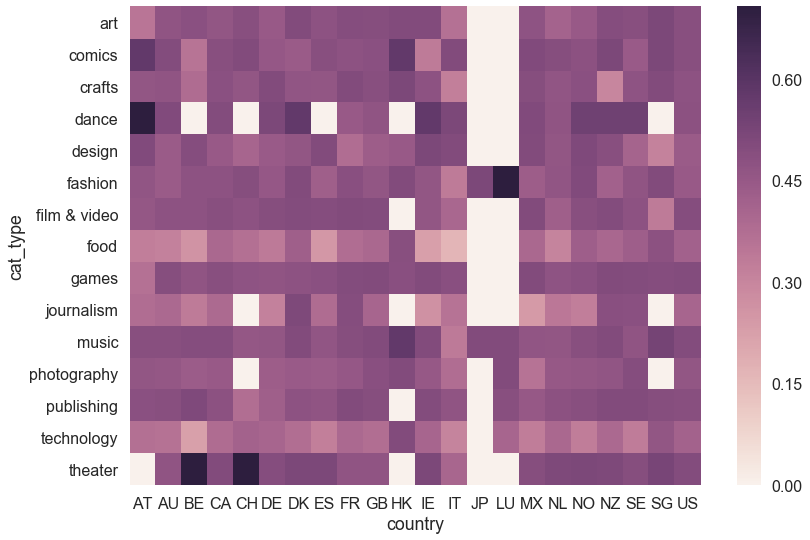

In [46]:
pt = df.pivot_table(index='cat_type',columns='country', aggfunc=np.std, values='succeeded', fill_value=0)#, margins=True)
chi2, p, dof, _ = chi2_contingency(pt.values)
print(chi2, p, dof)
sns.heatmap(pt)

3109.33992939 0.0 294


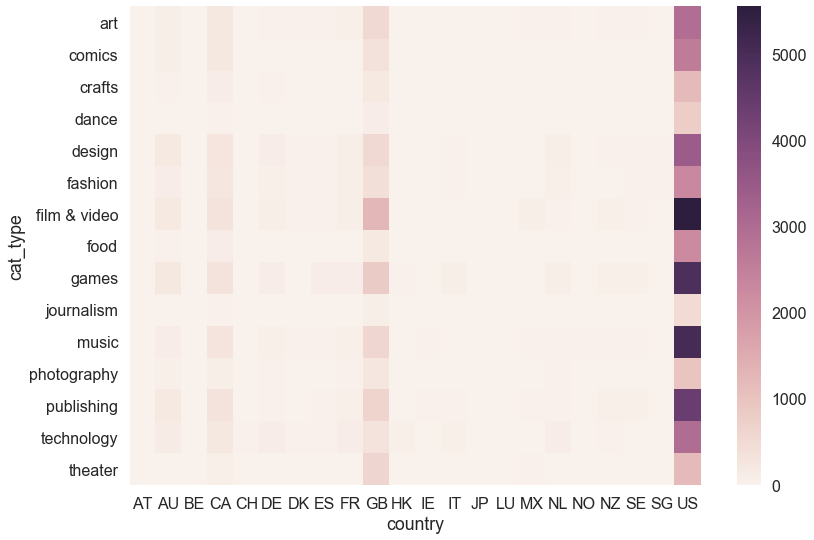

In [47]:
pt = df.pivot_table(index='cat_type',columns='country', aggfunc=np.sum, values='succeeded', fill_value=0)#, margins=True)
chi2, p, dof, _ = chi2_contingency(pt.values)
print(chi2, p, dof)
sns.heatmap(pt)

0.302744015927 1.0 21


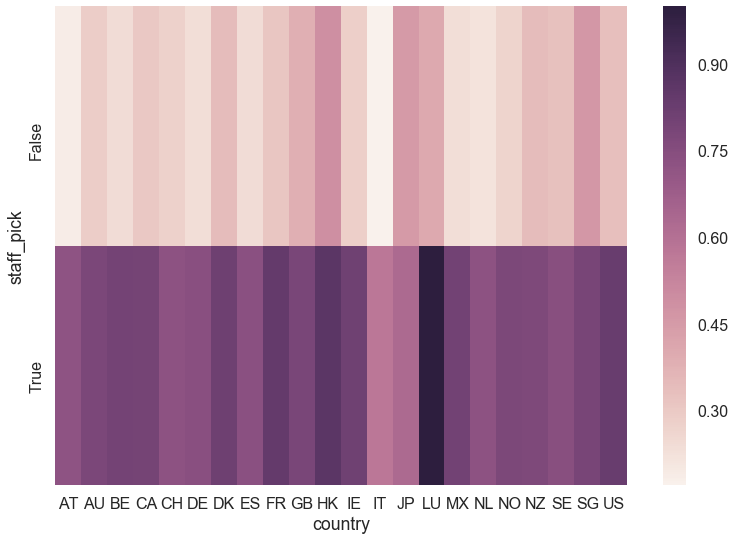

In [48]:
pt = df.pivot_table(index='staff_pick',columns='country', aggfunc=np.mean, values='succeeded', fill_value=0)#, margins=True)
chi2, p, dof, _ = chi2_contingency(pt.values)
print(chi2, p, dof)
sns.heatmap(pt)

cat_type
art             2.323976
comics          1.728211
crafts          2.639894
dance           1.603737
design          1.398602
fashion         2.984789
film & video    2.292220
food            3.985004
games           1.746525
journalism      4.919915
music           2.201201
photography     2.936032
publishing      2.600200
technology      4.435382
theater         1.741415
dtype: float64


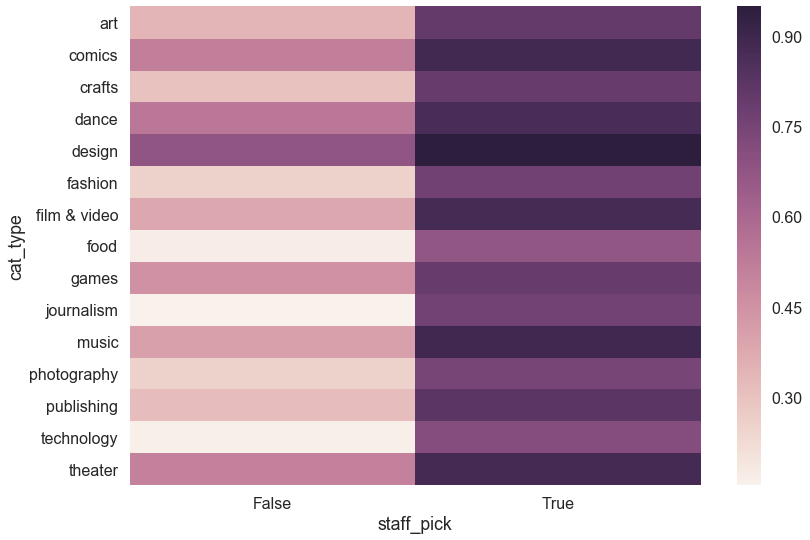

In [49]:
pt = df.pivot_table(index='cat_type',columns='staff_pick', aggfunc=np.mean, values='succeeded', fill_value=0)#, margins=True)
sns.heatmap(pt)
#print(pt)
pt.columns = ['false', 'true']
print(pt.true/pt.false)

ANOVA for success rates in different categories.
Statistical significance of correlation between goals and pledges